In [3]:
import sys
!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 KB 261.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 240.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 268.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 MB 205.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 KB 37.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 KB 146.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 222.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate
#from pycbc.catalog import Merger
import pylab
from pycbc.types import  FrequencySeries, TimeSeries

from scipy import interpolate

import numpy as np
from pycbc import frame
import pycbc
from pycbc.filter import resample_to_delta_t, highpass
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm 
from pycbc.detector import Detector
from scipy.interpolate import interp1d

import pylab
from pycbc.filter import highpass

from pycbc import types 
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
from pycbc.waveform import get_td_waveform
import pycbc.psd
from pycbc.psd import interpolate

import scipy

from pycbc.filter import sigmasq


# **1st Assignment - Matching filters**

**Part 1**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
d = np.load('/content/drive/MyDrive/GW_noisedata-2.npy') #name of the data file noise_ts_4096Hz.npy
dt = d[:, 0]
data_H1 = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0],epoch=dt[0]) #this is to comvert data into GW timeSeries
data_L1 = pycbc.types.TimeSeries(d[:, 2], delta_t = dt[1]- dt[0],epoch=dt[0]) #this is to comvert data into GW timeSeries
#merger = Merger("GW170817")
strain, stilde = {}, {}
strain['H1'] = resample_to_delta_t(highpass(data_H1, 15.0), 1.0/2048)
strain['L1'] = resample_to_delta_t(highpass(data_L1, 15.0), 1.0/2048)

strain['H1'] = strain['H1'].crop(4, 4)
strain['L1'] = strain['L1'].crop(4, 4)

stilde['H1'] = strain['H1'].to_frequencyseries()
stilde['L1'] = strain['L1'].to_frequencyseries()


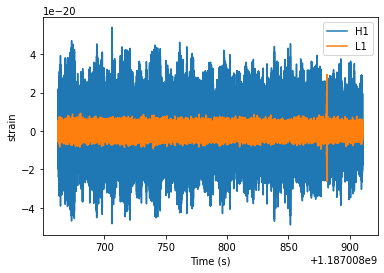

In [9]:
#print (strain.delta_t)
pylab.plot(strain['H1'].sample_times, strain['H1'], label= 'H1')
pylab.plot(strain['L1'].sample_times, strain['L1'], label= 'L1')
pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.show()


**Part 2**

In [10]:
#power spectral density
psds = {}
for ifo in ['L1', 'H1']:


    delta_t = strain[ifo].delta_t #sampling time
    seg_len = int(2 / delta_t) 
    seg_stride = int(seg_len / 2) #how much overlapping of the segments 
    psds[ifo]  = pycbc.psd.welch(strain[ifo],
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)
    
  

In [11]:
#creating gw waveform 

mass1 = np.arange(1, 3,0.001 ) #mass range bewteen 1 to 3 Solar mass
mass2 = mass1 

# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = []
 
for m in mass1:
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
    hp, hc = get_fd_waveform(approximant="TaylorF2",
                             mass1=m, mass2=m,
                             f_lower=20, delta_f=stilde[ifo].delta_f)
    hp.resize(len(stilde[ifo]))
   
    # Matched filter the data and find the peak 
    max_snr, max_time = {}, {}
    for ifo in ['L1', 'H1']:
        snr = matched_filter(hp, stilde[ifo], psd=psds[ifo], low_frequency_cutoff=20.0)
        snr_H1 = snr.crop(4 + 4, 4)
 
        # # The complex SNR at the peak
      
        _, idx = snr_H1.abs_max_loc()
        max_snr[ifo] = snr_H1[idx]
       
        # The time of the peak
    snrs.append(max_snr)



the best mass1=mass2 is 1.3759999999999586 solar masses


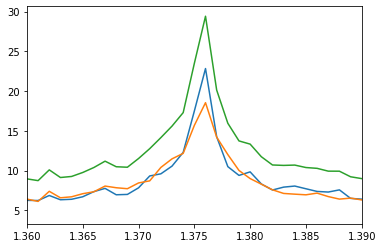

In [12]:
snrL1=[]
snrH1=[]
for snr in snrs:
  snrL1.append(np.abs(snr['L1']))
  snrH1.append(np.abs(snr['H1']))
nsnr=np.sqrt(np.array(snrL1)**2+np.array(snrH1)**2)
pylab.plot(mass1,snrL1)
pylab.plot(mass1,snrH1)
pylab.plot(mass1,nsnr)
pylab.xlim(1.360,1.390)

#mass of max snr
max_index=np.where(nsnr==max(nsnr))
print('the best mass1=mass2 is {} solar masses'.format(mass1[max_index][0]))

note that the snr is greater than 8, which is the threshold. therefore, the data have a signal 

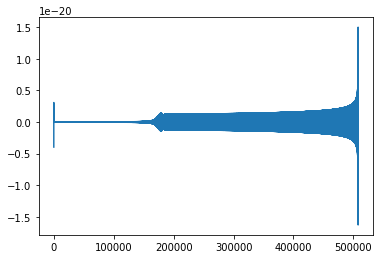

In [13]:
#recreating template using the mass that maximises our snr
m = 1.38 # Solar masses
conditioned = stilde['H1']
hp, hc = get_fd_waveform(approximant="TaylorF2",
                     mass1=m,
                     mass2=m,
                     delta_f=conditioned.delta_f,
                     f_lower=20)

# We will resize the vector to match our data
hp.resize(len(conditioned))

template = hp .cyclic_time_shift(hp.start_time)
pylab.plot(template.to_timeseries())
pylab.show()

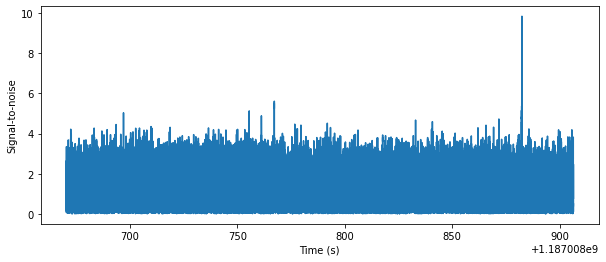

We found a signal at 1187008882.425879s with SNR 9.836596697567764


In [14]:
#new fitting with new data
ifo = 'L1'                            
conditioned = strain[ifo]
snr = matched_filter(template, conditioned,
                     psd=psds[ifo] , low_frequency_cutoff=15)

snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

In [15]:
from pycbc.filter import sigma

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

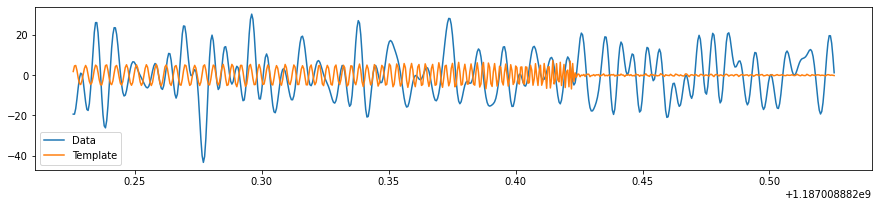

In [16]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(15, 400, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

white_data = white_data.highpass_fir(15., 400).lowpass_fir(200, 400)
#white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(time-.2, time+.1)
white_template = white_template.time_slice(time-.2, time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

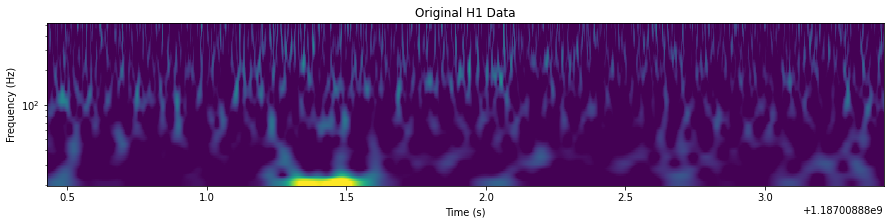

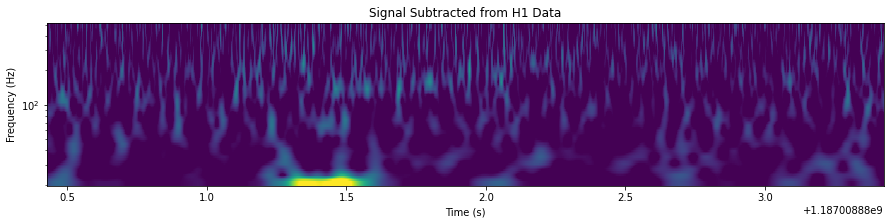

In [17]:
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(time - 2, time + 1)
    pylab.show()

**Part 3**

In [18]:
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter import match
m = 10
f_low = 30
rate = 4096
ms = []
hp,hc = get_td_waveform(approximant="TaylorT2",
                      mass1=m,
                      mass2=m,
                      delta_t=1/rate,
                      f_lower=f_low)
masses = np.arange(5,15,0.2)
sps = []
for mass in masses:
  sp,sh = get_td_waveform(approximant="TaylorT2",
                      mass1=mass,
                      mass2=mass,
                      delta_t=1/rate,
                      f_lower=f_low)
  sps.append(sp)


tlen = max(len(hp),len(sps[0]))

hp.resize(tlen)
for sp in sps:
  sp.resize(tlen)

for sp in sps:
  delta_f = 1.0/sp.duration
  flen = tlen//2+1
  psd = aLIGOZeroDetHighPower(flen,delta_f,f_low)
  m,i = match(hp,sp,psd=psd,low_frequency_cutoff=f_low)
  ms.append(m)

In [19]:
print(ms)

[0.07358250101538963, 0.07729799217784734, 0.08125934115173156, 0.08501431449042203, 0.08930893409066885, 0.09424638289758004, 0.09946558385599763, 0.1042247727323123, 0.11002276329591391, 0.11461743086704969, 0.12038504291305839, 0.12820314324238338, 0.13633735306747882, 0.1455064146928853, 0.15575758615287189, 0.16614316235869342, 0.1781532784678423, 0.19250911577026228, 0.20637668084496416, 0.2259806952938997, 0.24962551942600542, 0.2818374881718904, 0.33368275751824017, 0.42409897272058267, 0.5975665850835797, 0.9999999999999998, 0.6286397897297402, 0.46884750991236795, 0.3793890053442538, 0.3163234479307496, 0.30299800951036926, 0.26738581749863616, 0.2635978619242664, 0.2436556157371398, 0.23486179390456133, 0.23001679964924468, 0.22408428967712063, 0.21335590232002175, 0.2054279002384911, 0.20079684820471766, 0.19892804247493867, 0.196675636859029, 0.19487450070212967, 0.19218251667799466, 0.18928698917322537, 0.18582255879188284, 0.183589701019283, 0.18003319493093875, 0.178880

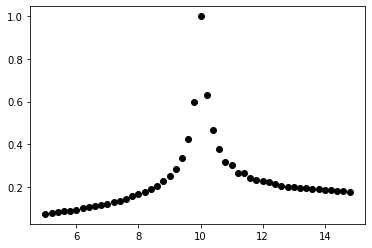

In [20]:
pylab.plot(masses,ms,'o',color='black');


# **2nd Assignment - Detector noise**

In [16]:
#Problem 2
#first download the data from the assignament 

'''
Loading the data and converting the data type into time series
'''
d = np.load('/content/drive/MyDrive/noise_ts_4096Hz.npy') #name of the data file noise_ts_4096Hz.npy
dt = d[:, 0]
d = types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) #this is to comvert data into GW timeSeries
data = d

In [17]:
strain=resample_to_delta_t(highpass(data, 15.0), 1.0/2048).crop(4,4)#applying an high pass filter and downsampling
stilde=strain.to_frequencyseries()

**Part 1**

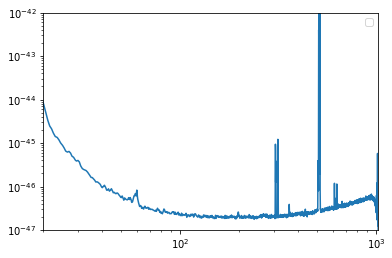

In [18]:
#determine noise power spectral density and test weather these is any gw sign (threshold=8)
psds = {}

delta_t = strain.delta_t #sampling time
seg_len = int(2 / delta_t) 
seg_stride = int(seg_len / 2) #how much overlapping of the segments 
psds  = pycbc.psd.welch(strain,
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
psds = interpolate(psds, stilde.delta_f)

pylab.loglog(psds.sample_frequencies, psds, ) #psds power spectral density 
pylab.xlim(20, 1024)
pylab.ylim(1e-47, 1e-42)
pylab.legend()


In [43]:
#creating gw waveform 

mass1 = np.arange(5, 10,0.1 ) #mass range bewteen 5 to 10 Solar mass
mass2 = mass1 

# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = []
 
for m in mass1:
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
    hp, hc = get_fd_waveform(approximant="TaylorF2",
                             mass1=m, mass2=m,
                             f_lower=20, delta_f=stilde.delta_f)
    hp.resize(len(stilde))
   
    # Matched filter the data and find the peak 
    max_snr, max_time = {}, {}
    
    snr = matched_filter(hp, stilde, psd=psds, low_frequency_cutoff=20.0)
    snr_H1 = snr.crop(4 + 4, 4)
    
    snrs.append(max(abs(snr_H1)))

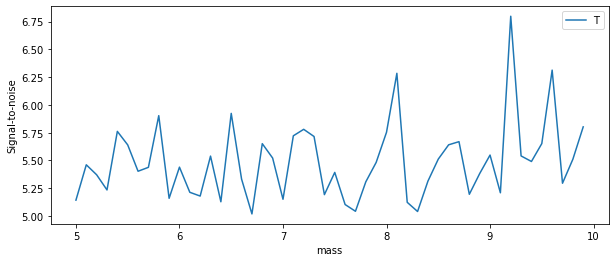

In [44]:
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs)
pylab.legend('True')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

signal to noise ratio is less than the threshold. Threfore, no detectable signal in the data.

**Part 2** 

Text(0, 0.5, 'probability')

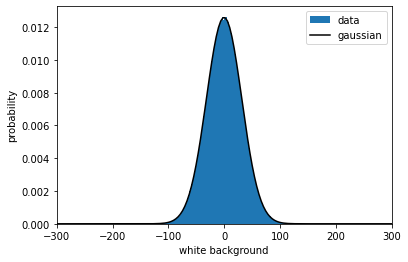

In [48]:
#whitening data 
white_data = (strain.to_frequencyseries() / psds**0.5).to_timeseries()
white_data = white_data.crop(4,4)
#histogram of the whitened data
hist = pylab.hist(white_data,bins=300,density=True,label='data')

#gausiann (data to a normal distribution)
limits = (-300, 300)
mean,sd = norm.fit(white_data)
lns = np.linspace(*limits, 150)
gauss = norm.pdf(lns,mean,sd)
#plotting --fix the plotting (or the fitting)
pylab.plot(lns,gauss,'k',label='gaussian');
pylab.xlim(*limits);
pylab.legend();
pylab.xlabel("white background")
pylab.ylabel("probability")


**Part 3**

In [65]:
hp, hc = get_fd_waveform(approximant="TaylorF2", 
                         mass1=3, mass2=3, 
                         delta_f=1.0/(200.0),
                         distance = 500, 
                         f_lower=20.0, 
                         f_final = 2048.0) 
psds = pycbc.psd.interpolate(pycbc.psd.welch(data),hp.delta_f)
snr = (pycbc.filter.sigmasq(hp, psds))**0.5 

In [73]:
chunks = 650
data_sliced = len(data)/chunks
data_sliced = int(data_sliced)

snrs = []
for i in range(0,chunks):
  data_chunk = data[i*data_sliced : (i+1)*data_sliced]
  psds = pycbc.psd.interpolate(pycbc.psd.welch(data_chunk),hp.delta_f)
  snr = (pycbc.filter.sigmasq(hp, psds))**0.5
  snrs.append(snr)

Text(0, 0.5, 'Probability')

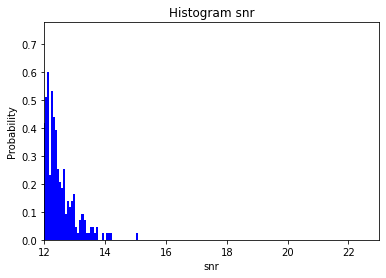

In [74]:
fig, ax = plt.subplots()

n, bins, patches = plt.hist(snrs, color = 'blue', density=True, bins = int(100))

plt.title('Histogram snr')
plt.xlabel('snr')
plt.xlim(12,23)
plt.ylabel('Probability')


the histogram shows that the background is not statioanry give the "unstable" movement of the peaks. Moreover, it shouyld be noticed that most events are grouped together, which allows the assumption of having a constant background noise. 

# **Assignment 3 - horizon distance of detectors**

**Part 1**

In [75]:
flow = 4.0 # set up the lower cut off frequency
delta_f = 1.0 / 16
flen = int(2048.0/ (delta_f)) + 1
psd_ligo = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
psd_ligo.data[:int(flow/delta_f)] = np.inf 
psd_ligo.data[-1] = np.inf

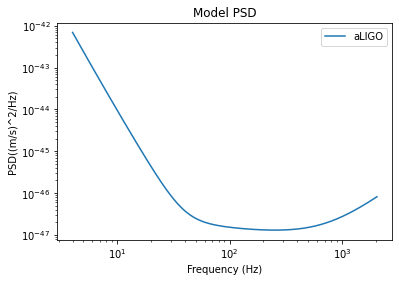

In [76]:
pylab.loglog(psd_ligo.sample_frequencies, psd_ligo)
pylab.title('Model PSD')
pylab.legend(['aLIGO'])
pylab.xlabel('Frequency (Hz)')
pylab.ylabel('PSD((m/s)^2/Hz)')
pylab.show()

In [77]:
#Horizon Distance for aLIGO detector
hp, hc = get_fd_waveform(approximant="TaylorF2",
                           mass1=5, mass2=5,
                           f_lower=flow, 
                           delta_f=delta_f,
                           distance = 1000)
snr = (pycbc.filter.sigmasq(hp, psd_ligo))**0.5

In [78]:
horz_d = 1000*(snr/8)
hp, hc = get_fd_waveform(approximant="TaylorF2",
                           mass1=5, mass2=5,
                           f_lower=flow, 
                           delta_f=delta_f,
                           distance = horz_d)
from pycbc.filter import sigmasq
snr = (pycbc.filter.sigmasq(hp, psd_ligo))**0.5
print(snr)
print(horz_d)

8.0
1279.098426652081


In [79]:
mass1 = np.arange(5,500,5) 
mass2 = mass1

hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
horz_dist = []
masses = []
dist = 1000 #Mpc
len_mass1 = range(len(mass1))
for i in len_mass1:
    m = mass1[i]
    masses.append(m*2)
    hp, hc = get_fd_waveform(approximant="TaylorF2",
                           mass1=m, mass2=m,
                           f_lower=flow, 
                           delta_f=delta_f,
                           distance = dist)

    snr = (pycbc.filter.sigmasq(hp, psd_ligo))**0.5
    horz_dist.append(dist*(snr/8)/1000) 

Text(0, 0.5, 'Horizon Distance (GPc)')

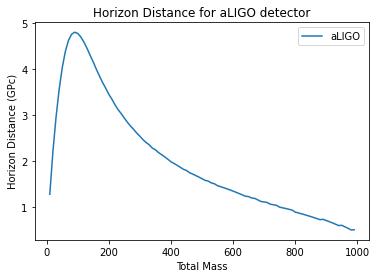

In [80]:
#plotting Horizon Distance for aLIGO detector
pylab.plot(masses ,horz_dist)
pylab.legend(['aLIGO'])
pylab.title('Horizon Distance for aLIGO detector')
pylab.xlabel('Total Mass')
pylab.ylabel('Horizon Distance (GPc)')

**Part 2**

Massive balck holes have a high amplitude and low frequency. Therefore, the power spectral density is affected by being high. Power specral density are related by the formula given in the assignment, which correlates psd which is invesrly proportional to the sqrt of the horizon distance. 
The peak and decrease afterwards might be because of binary merging systems (which in this case can be two super massive black holes).